## Test of DetSim

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy     as np
import pandas    as pd
from   scipy     import stats
import os
import matplotlib.pyplot as plt

import xyimg.dataprep as dp
import xyimg.detsim   as dsim
#import xyimg.cnn      as cnn

## Tests

In [3]:
pressure = '5bar'
sample   = '1eroi'

path      = os.environ['LPRDATADIR']
ifilename = path + dp.voxel_filename(pressure, sample)
ofile     = 'temp.h5'


In [4]:
dsim.test(ifilename)

True

In [5]:
voxels = pd.read_hdf(ifilename, 'voxels')

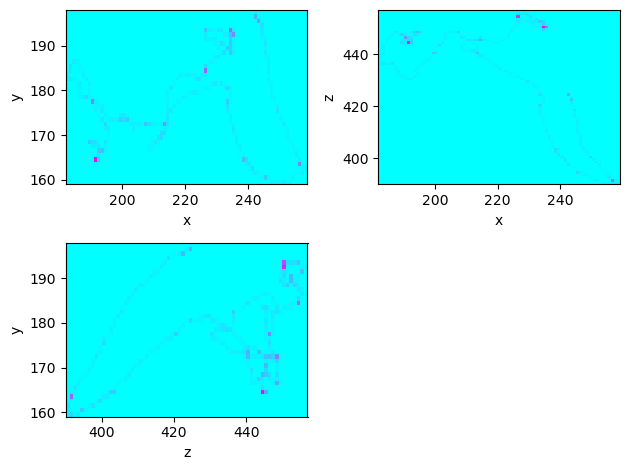

In [6]:
ievt = 1
evt = dsim.df_event(voxels, 1, ievt)
width = (2., 2., 2.)
bins = [dsim.mmbins(xi, wi) for wi, xi in zip(width, (evt.x, evt.y, evt.z))]
dsim.plot_event(evt, scatter = False, bins = bins)

,file_id,event,x,y,z,E,binclass,segclass,track_id,nhits,ext,nielectron
0,1,1,182.633205,182.608350,436.328884,25.637616,0,1,0,2,0,151
1,1,1,182.636667,182.909012,436.264590,25.637616,0,1,0,2,0,151
2,1,1,182.516873,182.883988,436.926661,25.637616,0,1,0,2,0,151


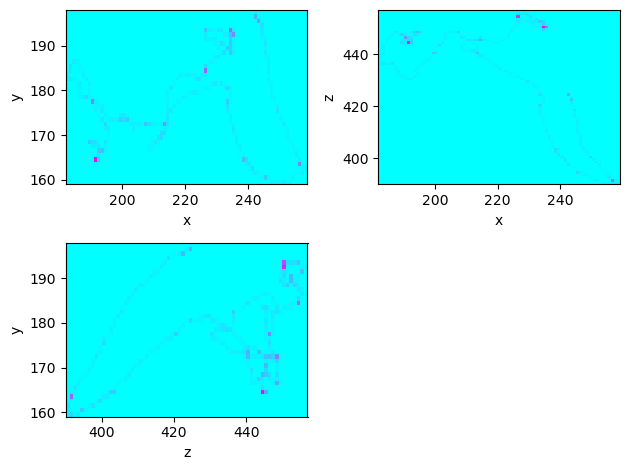

In [8]:
width = (2., 2., 2.)
dfie = dsim.df_ielectrons(evt, width)
dsim.plot_event(dfie, scatter = False, bins = bins)
dfie[:3]

True

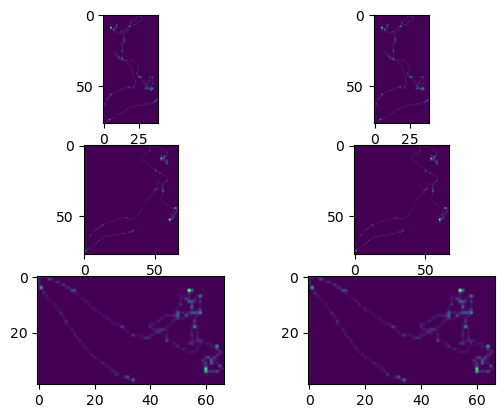

In [10]:
dsim.test_df_ielectrons(evt, width, plot = True)

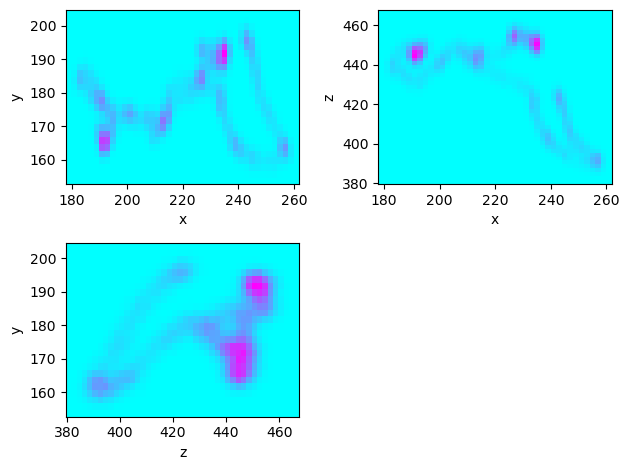

In [11]:
dfie0 = dfie.copy()
sigma = (1, 2, 3)
dfie = dsim.df_norma(dfie, sigma)
dsim.plot_event(dfie, scatter = False)

,file_id,event,x,y,z,E,binclass,segclass,track_id,nhits,ext,nielectron
0,1,1,181.337087,182.359341,436.711234,25.637616,0,1,0,2,0,151
1,1,1,182.520556,187.089458,436.456662,25.637616,0,1,0,2,0,151
2,1,1,178.903917,184.944897,439.112834,25.637616,0,1,0,2,0,151


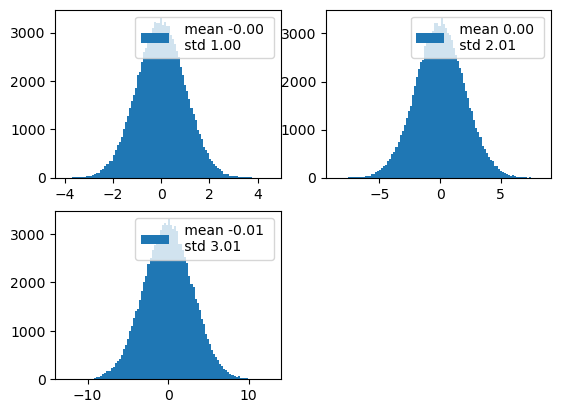

In [12]:
dsim.test_df_norma(dfie, sigma, plot = True)
dfie[:3]

In [13]:
width   = (2, 2, 2)
dfvoxel = dsim.df_voxalize(dfie, width)
dfvoxel[:3]

,,,file_id,event,x,y,z,E,binclass,segclass,track_id,nhits,ext,nielectron,ix,iy,iz
ix,iy,iz,,,,,,,,,,,,,,,
1,34,70,1,1,175.552686,181.961784,444.427452,25.637616,0,1,0,2.0,0,1,1,34,70
2,37,67,1,1,177.305913,185.391434,441.703002,25.824920,0,1,0,1.0,0,1,2,37,67
3,34,68,1,1,178.411052,181.530352,442.323478,25.637616,0,1,0,2.0,0,1,3,34,68


In [14]:
dsim.test_df_voxalize(dfie, width)

True

### Run DF

In [17]:
width   = (2, 2, 2)
sigma   = (4, 4, 4)
nevents = 10
dv      = dsim.run(ifilename, ofile, width, sigma, width, nevents = nevents)

input  filename  /scratch/next/data/NEXT100/pressure_topology/voxel_dataset_5bar_1eroi.h5
output filename  temp.h5
width-0    (mm)  (2, 2, 2)
sigmas     (mm)  (4, 4, 4)
widths-1   (mm)  (2, 2, 2)
wi         (eV)  25.6
use DF           True
events           10


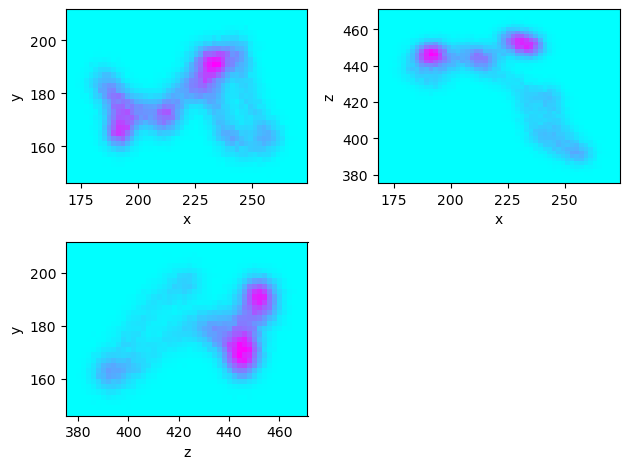

In [19]:
xevt = dsim.df_event(dv, 1, ievt)
dsim.plot_event(xevt)

## Test NP

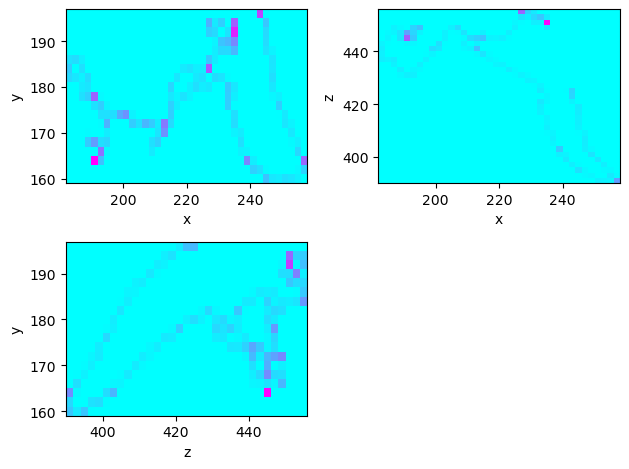

In [22]:
ievt = 1
evt  = dsim.df_event(voxels, 1, ievt)
dsim.plot_event(evt)

In [30]:
def to_df(pos, ene):
    return pd.DataFrame({'x' :pos[0], 'y' : pos[1], 'z' : pos[2], 'E' : ene}) 


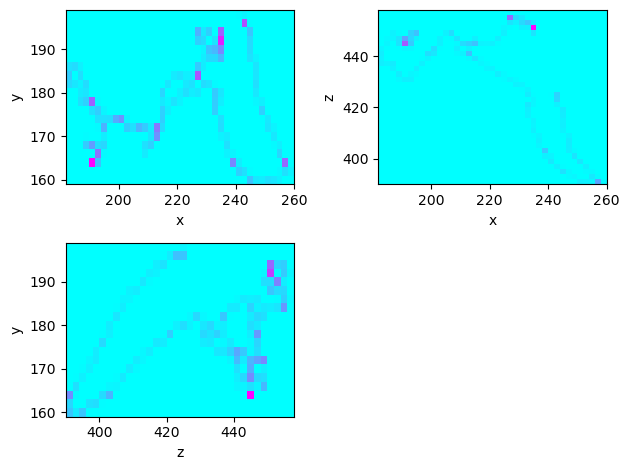

In [43]:
width = (2, 2, 2)
pos, ene   = [evt[label].values for label in ('x', 'y', 'z')], 1e6*evt.E.values
ie_pos, ie_ene = dsim.ielectrons(pos, ene, width)
ddie = to_df(ie_pos, ie_ene)
dsim.plot_event(ddie)

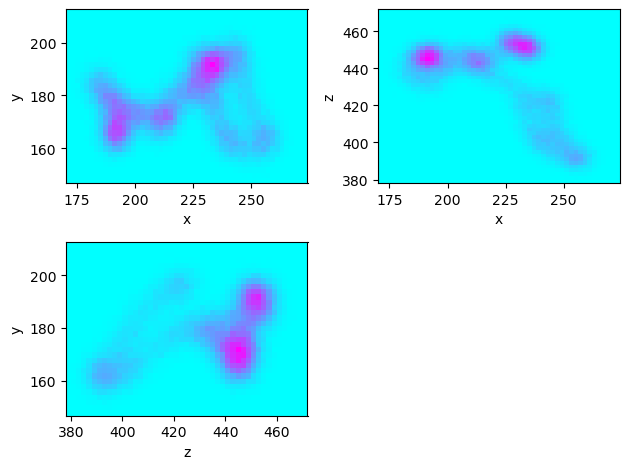

In [45]:
sigma   = (4, 4, 4)
ie_pos2 = dsim.ielectrons_diffuse(ie_pos, sigma)
ddie2   = to_df(ie_pos2, ie_ene)
dsim.plot_event(ddie2)

In [58]:
ddv = dsim.diff_ievoxel(evt, width, sigma, width)
ddv[:3]

,file_id,event,x,y,z,E,binclass,segclass,ext,track_id,nhits,nielectron
0,1,1,170.396182,191.262277,440.020852,25.590734,0,0,0,0,0,1
1,1,1,171.779792,177.893582,434.238332,25.553186,0,0,0,0,0,1
2,1,1,172.266762,183.633501,438.771062,25.635369,0,0,0,0,0,1


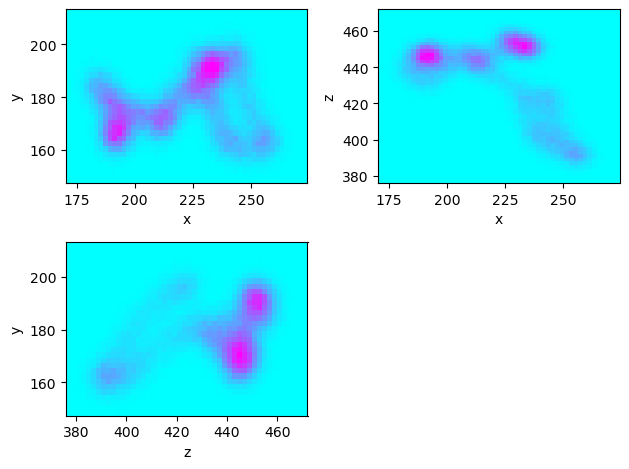

In [59]:
dsim.plot_event(ddv)

In [66]:
width   = (2, 2, 2)
sigma   = (4, 4, 4)
nevents = 100
ddv      = dsim.run(ifilename, ofile, width, sigma, width, use_df = False, nevents = nevents)

input  filename  /scratch/next/data/NEXT100/pressure_topology/voxel_dataset_5bar_1eroi.h5
output filename  temp.h5
width-0    (mm)  (2, 2, 2)
sigmas     (mm)  (4, 4, 4)
widths-1   (mm)  (2, 2, 2)
wi         (eV)  25.6
use DF           False
events           100


In [70]:
ddv.event.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57])

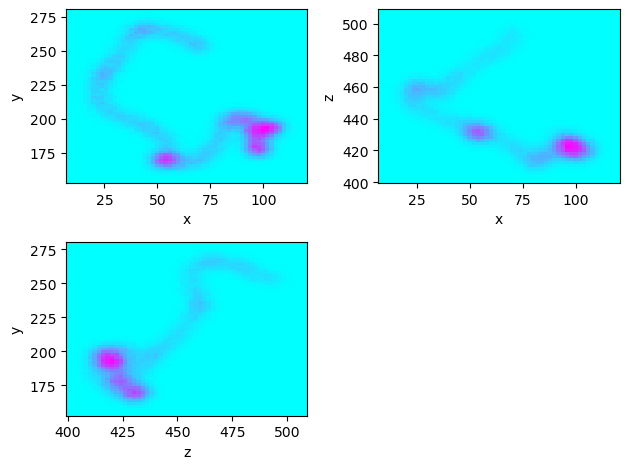

In [72]:
ievt = 55
evt  = dsim.df_event(ddv, 1, 55)
dsim.plot_event(evt)

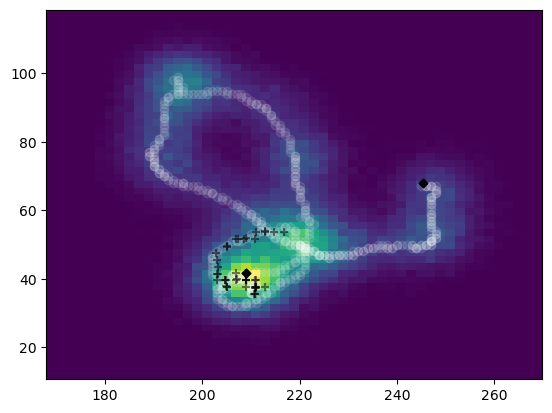

In [269]:
i0, i1 = 1, 2
plt.hist2d(xpos[i0], xpos[i1], weights = xene, bins = (bins[i0], bins[i1]));
plt.scatter(pos[i0], pos[i1], alpha = 0.1, color = 'white')
plt.scatter(xpos[i0][xsegclass == 3], xpos[i1][xsegclass == 3], alpha = .5, color = 'black', marker='+')
plt.scatter(xpos[i0][xext > 0], xpos[i1][xext > 0], alpha = 1., color = 'black', marker='D', s = 20)



In [48]:
np.sum(ene), np.sum(ie_ene)

(2.457999998430296, 2.457999998430296)

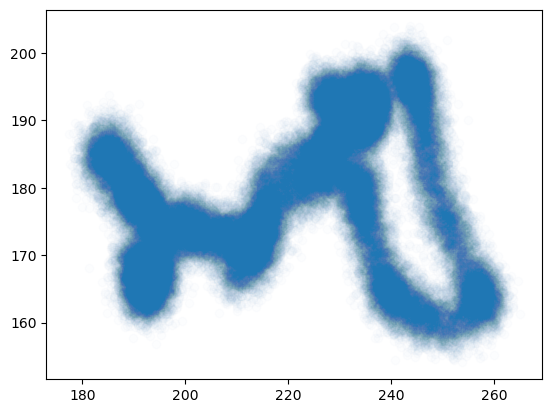

In [54]:
plt.scatter(ie_pos[0], ie_pos[1], alpha = 0.01)

In [1]:
ievt = evt[['x', 'y', 'z', 'E']]

NameError: name 'evt' is not defined

In [62]:
ievt

,x,y,z,E
490,182,182,436,0.003871
491,182,182,437,0.001494
492,182,182,438,0.001365
493,182,183,438,0.002234
494,182,183,439,0.005366
...,...,...,...,...
919,256,164,392,0.003523
920,257,161,390,0.006627
921,257,162,391,0.003436
922,257,163,391,0.004179


In [63]:
np.sum(ievt.E)

2.457999998430296

In [40]:
smear = dsim.get_smear(0., 0., 0.)

In [41]:
svoxels = [smear(voxel.x, voxel.y, voxel.z, voxel.E) for i, voxel in ievt.iterrows()]

In [44]:
ie_pos = [np.concatenate([s[i] for s in svoxels]) for i in range(2)]
ie_ene = np.concatenate([s[3] for s in svoxels])

In [58]:
width = 2.
bins  = [np.arange(np.min(x) - 2.*width, np.max(x) + 2.*width, width) for x in ie_pos]

In [59]:
img , _, _ = stats.binned_statistic_dd(ie_pos, ie_ene,  bins = bins, statistic = 'count')

In [60]:
np.sum(img) * 25.*1e-6

2.4006499999999997

In [61]:
np.sum(ie_ene)

2458265.6

In [39]:
len(xs)

96026

In [33]:
x, y, z, E = [evt[label].values for label in ('x', 'y', 'z', 'E')]

In [62]:
ivoxel = 0
wi     = 25.
x0, y0, z0, E0 = x[ivoxel], y[ivoxel], z[ivoxel], E[ivoxel]
nsize = int(np.round(1e6*E0/wi))
print(x0, y0, z0, E0, nsize)

182 182 436 0.003871280001476407 155


In [73]:
smear                = dsim.get_smear(25., 2., 2., 2.)
positions, energies  = smear((x[ivoxel], y[ivoxel], z[ivoxel]), E[ivoxel])

In [74]:
white = 20 # mm
voxel_width = 2. #3 mm
frames = [(np.min(x) - white , np.max(x) + white) for x in (x, y, z)] 
bins   = [np.arange(*iframe, voxel_width) for iframe in frames]


In [75]:
index = (0, 1)
coors = [positions[i] for i in index]
cbins = [bins[i]    for i in index]
var   = energies
img , _, _ = stats.binned_statistic_dd(coors, var,  bins = cbins, statistic = 'count')

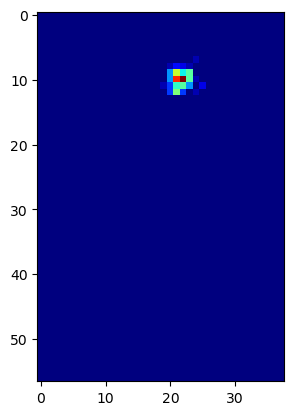

In [76]:
plt.imshow(img, cmap = 'jet')

In [ ]:
result = evt[['x', 'y', 'z', 'E']]

: 